In [1]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from scipy import stats
from analysis_functions import *

# Filter out a certain event

In [2]:
#load all dataframes (already filtered for the news channels except for the channel dataframe)
filtered_df_vid = pl.read_csv("./../data/filtered_yt_metadata_helper.feather.csv")
df_ch = pl.read_csv("./../data/df_channels_en.tsv", separator='\t')
filtered_df_ch = df_ch.filter(pl.col("category_cc") == "News & Politics")
filtered_df_timeseries = pl.read_csv("./../data/filtered_df_timeseries_en.tsv", separator='\t')
num_comments = pl.read_csv("./../data/num_comments.tsv", separator='\t')

In [3]:
#rename channel id columns to all have the same name
filtered_df_ch = filtered_df_ch.rename({'channel':'channel_id'})
filtered_df_timeseries = filtered_df_timeseries.rename({'channel':'channel_id'})

In [4]:
filtered_df_vid = filtered_df_vid.filter(pl.col('categories') == 'News & Politics')
filtered_df_vid

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
i64,str,str,f64,str,i64,f64,str,f64
24361,"""News & Politics""","""UCzUV5283-l5c0oKRtyenj6Q""",195.0,"""MBgzne7djFU""",378,47027.0,"""2019-10-03""",374711.0
24362,"""News & Politics""","""UCzUV5283-l5c0oKRtyenj6Q""",114.0,"""AbH3pJnFgY8""",278,36384.0,"""2019-10-02""",245617.0
24363,"""News & Politics""","""UCzUV5283-l5c0oKRtyenj6Q""",143.0,"""QBuwj_h1SH4""",385,40597.0,"""2019-10-01""",299535.0
24364,"""News & Politics""","""UCzUV5283-l5c0oKRtyenj6Q""",193.0,"""Reogq26-KpI""",419,42658.0,"""2019-09-30""",357126.0
24365,"""News & Politics""","""UCzUV5283-l5c0oKRtyenj6Q""",136.0,"""uBY9OtlSnX8""",414,44246.0,"""2019-09-27""",297704.0
…,…,…,…,…,…,…,…,…
72924789,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",3.0,"""YQLoxwLpjSU""",270,67.0,"""2017-02-06""",4409.0
72924790,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",0.0,"""mINQHg1QBcg""",878,21.0,"""2017-02-06""",1172.0
72924791,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",2.0,"""x20aNOWh1yI""",1003,35.0,"""2017-02-06""",1898.0


In [5]:
#filter by date
min_date = pl.datetime(2018,1,1)
max_date = pl.datetime(2019,1,1)

filtered_df_timeseries = filtered_df_timeseries.with_columns(pl.col('datetime').str.to_datetime())
filtered_df_vid = filtered_df_vid.with_columns(pl.col('upload_date').str.to_datetime())

filtered_df_timeseries = filtered_df_timeseries.filter((pl.col('datetime') >= min_date) & (pl.col('datetime') <= max_date))
filtered_df_vid = filtered_df_vid.filter((pl.col('upload_date') >= min_date) & (pl.col('upload_date') <= max_date))
filtered_df_ch = filtered_df_ch.filter(pl.col('channel_id').is_in(filtered_df_vid['channel_id']))
filtered_num_comments = num_comments.filter(pl.col('display_id').is_in(filtered_df_vid['display_id']))

In [6]:
#create dictionnary to more easily navigate between channel name and channel id
channel_dict = dict(df_ch[['name_cc','channel']].iter_rows())
inv_channel_dict = {v: k for k, v in channel_dict.items()}

In [7]:
filtered_df_vid = filtered_df_vid.join(filtered_num_comments, on='display_id')

# Identify holes in the data
    - channels that don’t report for specific events
    - videos with too few comments (under 50 it is not in the comment dataset)

In [9]:
#datasets for first event
timeseries_1 = filtered_df_timeseries
videos_1 = filtered_df_vid
num_comments_1 = filtered_num_comments
channels_1 = filtered_df_ch

In [9]:
#datasets for second event
timeseries_2 = filtered_df_timeseries
videos_2 = filtered_df_vid
num_comments_2 = filtered_num_comments
channels_2 = filtered_df_ch

### Looking for channels that do not report on certain events

In [8]:
# channels that report on event1 but not on event2
channels_1.filter(~pl.col('channel_id').is_in(channels_2['channel_id']))

category_cc,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
str,str,str,str,i64,i64,f64,f64


In [9]:
# channels that report on event2 but not on event1
channels_2.filter(~pl.col('channel_id').is_in(channels_1['channel_id']))

category_cc,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
str,str,str,str,i64,i64,f64,f64


### Filtering out videos with too few comments

In [8]:
#the videos with too few comments can be excluded by filtering
comment_threshold = 100

too_few_comments = filtered_num_comments.filter(pl.col('num_comms') < comment_threshold) #100 is an arbitrary choice

#videos with not enough comments
filtered_df_vid.filter(pl.col('display_id').is_in(too_few_comments['display_id']))

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,num_comms
i64,str,str,f64,str,i64,f64,datetime[μs],f64,f64
47822,"""News & Politics""","""UCzSq7O3MmG-EF0Gq68uSjPw""",0.0,"""YggfYSJXVFI""",156,21.0,2018-12-31 00:00:00,264.0,5.0
47823,"""News & Politics""","""UCzSq7O3MmG-EF0Gq68uSjPw""",0.0,"""TeSiH68wrC8""",221,10.0,2018-12-29 00:00:00,390.0,3.0
47824,"""News & Politics""","""UCzSq7O3MmG-EF0Gq68uSjPw""",35.0,"""D1Jfp3nbqco""",241,49.0,2018-12-29 00:00:00,5094.0,32.0
47825,"""News & Politics""","""UCzSq7O3MmG-EF0Gq68uSjPw""",0.0,"""HvWUDtdN9Ko""",143,10.0,2018-12-25 00:00:00,156.0,3.0
47826,"""News & Politics""","""UCzSq7O3MmG-EF0Gq68uSjPw""",0.0,"""NqyJsbkfGsc""",135,8.0,2018-12-25 00:00:00,118.0,1.0
…,…,…,…,…,…,…,…,…,…
72920185,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",5.0,"""SuMhd8mR7Ms""",58,174.0,2018-08-21 00:00:00,2153.0,3.0
72920186,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",53.0,"""462uEoGZoUI""",11585,1403.0,2018-08-20 00:00:00,47502.0,30.0
72920187,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",22.0,"""NhT82pXVbWk""",405,327.0,2018-08-20 00:00:00,21923.0,25.0


# Compare channels
    - this channels videos, have these characteristics, or perform well with these subjects

### Channels with correlated video performances (view count, likes, dislikes, number of comments)

In [36]:
#get general statistics for all channel
#gives information on the general performance characteristics of the videos from each channel
grouped_vids = filtered_df_vid.join(filtered_num_comments, on='display_id')
vid_count, vid_mean, vid_std, vid_med = get_general_ch_statistics(grouped_vids, cols_to_keep=['dislike_count','like_count','view_count','num_comms','duration'])

In [10]:
df = filtered_df_vid.drop_nulls()

In [11]:
stats.pearsonr(df['like_count'].drop_nulls(), df['dislike_count'].drop_nulls())

PearsonRResult(statistic=0.5386897709945648, pvalue=0.0)

In [11]:
df = filtered_df_vid[['dislike_count','duration','like_count','view_count','num_comms']].drop_nulls()

In [12]:
df_standardized = stats.zscore(pd.DataFrame(df), axis=1)

In [13]:
cov = df_standardized.corr()
metrics = ['dislike_count','duration','like_count','view_count','num_comms']

In [ ]:
for i in filtered_df_.columns : 
    if i == '':
        print ('yes')

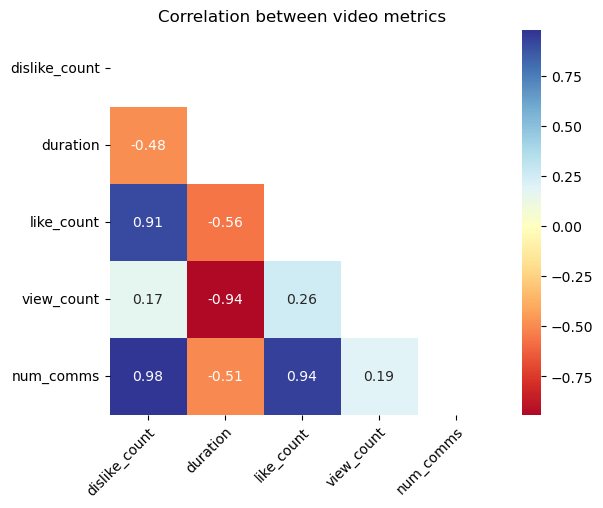

In [15]:
import seaborn as sns

cov = df_standardized.corr()
metrics = df.columns
mask = np.triu(np.ones_like(cov, dtype=bool))

plt.figure(figsize=(7, 5))
fig = sns.heatmap(cov, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap='RdYlBu')

fig.set_xticks(np.arange(len(metrics)) + 1/2, labels=metrics)
fig.set_yticks(np.arange(len(metrics))+ 1/2, labels=metrics)

plt.setp(fig.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.setp(fig.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")

plt.title('Correlation between video metrics')
plt.show()

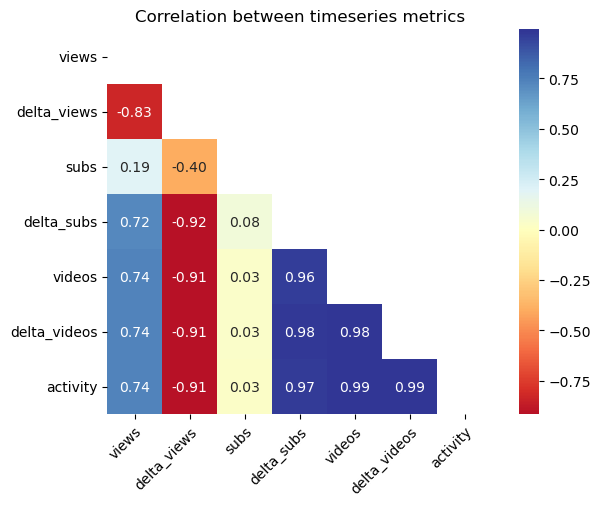

In [37]:
def plot_correlation_matrix (df, plot_title):
    """
    Plot the correlation matrix for a given dataframe.
    This works for the all three main datasets (channels, timeseries, video metadata)
    
    --------------------------------------------------------
    Parameters:
    df (pd.DataFrame): 
        The dataframe we want to plot.
        
    plot_title (string): 
        The title of the correlation matrix plot.
    
    --------------------------------------------------------    
    Returns:
    cov (pl.DataFrame)
        The covariance matrix for the given dataset
    """
    
    
    filtered_df = df.select(pl.col(pl.Float64, pl.Int64)).drop_nulls()
    
    for i in df.columns : 
        if i == '':
            filtered_df = filtered_df.drop('')
    
    df_standardized = stats.zscore(pd.DataFrame(filtered_df), axis=1)
    
    cov = df_standardized.corr()
    metrics = filtered_df.columns
    mask = np.triu(np.ones_like(cov, dtype=bool))

    plt.figure(figsize=(7, 5))
    fig = sns.heatmap(cov, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap='RdYlBu')

    fig.set_xticks(np.arange(len(metrics)) + 1/2, labels=metrics)
    fig.set_yticks(np.arange(len(metrics))+ 1/2, labels=metrics)

    plt.setp(fig.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(fig.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")

    plt.title(plot_title)
    plt.show()
    
    return cov
    
cov = plot_correlation_matrix(filtered_df_timeseries, 'Correlation between timeseries metrics')

In [27]:
df = filtered_df_ch
threshold = 2250

first_correlated_channel = df[np.where(np.tri(len(cov), k=-1) * cov > threshold)[0]]
second_correlated_channel = df[np.where(np.tri(len(cov), k=-1) * cov > threshold)[1]]

correlated_channels = first_correlated_channel.insert_column(1,second_correlated_channel[:,2].rename('channel_id_2'))[['channel_id','channel_id_2']]
correlated_channels.rename({'channel_id':'channel_id_1'})

channel_id_1,channel_id_2
str,str
"""UCpbE1CJWNHpu8knuok8YBZQ""","""UC69lWS7UMbBQc-9yqp4nGjA"""


In [32]:
print(inv_channel_dict["UCpbE1CJWNHpu8knuok8YBZQ"])
print(inv_channel_dict["UC69lWS7UMbBQc-9yqp4nGjA"])

Jenny Constantine
Patriotism Show


In [110]:
vid_mean.filter(pl.col('channel_id').is_in([channel_dict['SignsofThyComing'],channel_dict['FOX 2 St. Louis']]))

channel_id,dislike_count,like_count,view_count,num_comms,duration
str,f64,f64,f64,f64,f64
"""UClMs26ViHFMy7MS897Alcxw""",2.2273e-8,3.7075e-7,0.000057,0.440502,0.000023
"""UCPejB1cCtTCwzi9yk10CR3g""",5.6882e-7,0.000005,0.00023,36.5,0.000012


In [93]:
vid_mean.sample(5)

channel_id,dislike_count,like_count,view_count,num_comms,duration
str,f64,f64,f64,f64,f64
"""UCcoCpVnY1FE1nHujAbIq_ow""",0.000038,0.000581,0.010323,382.543478,0.000339
"""UCVrEv6xAiW71v-XwxHRTehg""",0.000001,0.000016,0.00113,31.487603,0.000186
"""UCoDyBtyP-3WC6z56EMMnj6A""",1.7965e-7,0.000001,0.000224,0.401859,0.000112
"""UCwnUz_hisrXU2hylXsz7Fmg""",0.000002,0.000011,0.002514,35.557742,0.000022
"""UCWTkpYvniGIUe1jeCncFzKw""",2.0932e-8,4.2403e-7,0.000078,1.375931,0.000002


### Channels with correlated video characteristics (length, key words?, ...)

##### !!! Note : Keyword analysis has not been added yet.

c:\Users\samue\Desktop\Box Sync\3.Samuel\Uni_24-25\ADA\ada-2024-project-lil0mohammadali\analysis_functions.py:136: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(df.drop('channel_id').drop_nulls())
c:\Users\samue\anaconda3\envs\adaenv\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\samue\anaconda3\envs\adaenv\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


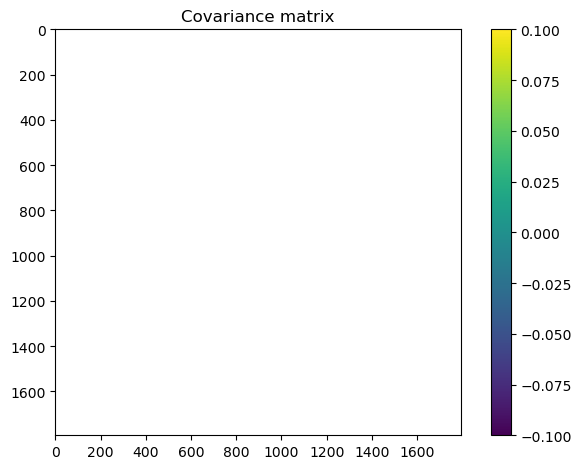

c:\Users\samue\anaconda3\envs\adaenv\Lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\samue\anaconda3\envs\adaenv\Lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

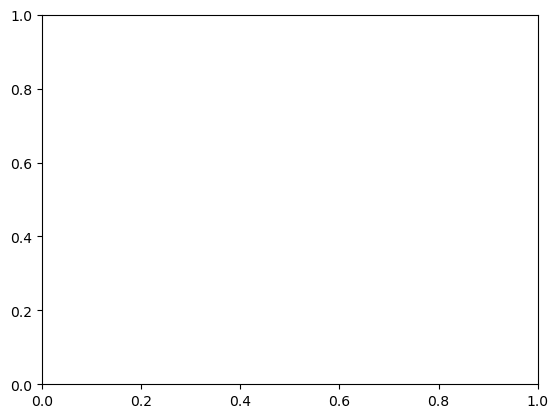

In [14]:
cov = plot_covariance(vid_mean.drop(['num_comms','like_count','dislike_count','view_count']), 'Covariance matrix', 'Histogram of covariances')

In [ ]:
get_correlated_channels(vid_mean.drop(['num_comms','like_count','dislike_count','view_count']), 1e10)

### More in depth comparaison between two given channels

Optional procedure to analyse more in depth the relation between two channels

##### Based on video dataframe

In [15]:
# ttest : checks the null hypothesis that two independant channels have an identical mean number of views, likes etc...
# used to compare if two sample's means differ significantly or not

ttest_between_two_channels(grouped_vids, channel_dict['ABC News'],channel_dict["CNN"], 'num_comms')

TtestResult(statistic=0.05519495356695619, pvalue=0.9559845823695244, df=7694.108275868283)

In [16]:
# F test : test for the null hypothesis that two channels have the same variance
# used to compare if two sample's variance differ significantly or not

Ftest_between_two_channels(grouped_vids, channel_dict['ABC News'],channel_dict["CNN"], 'num_comms')

F_onewayResult(statistic=0.003545606501928798, pvalue=0.9525190162068249)

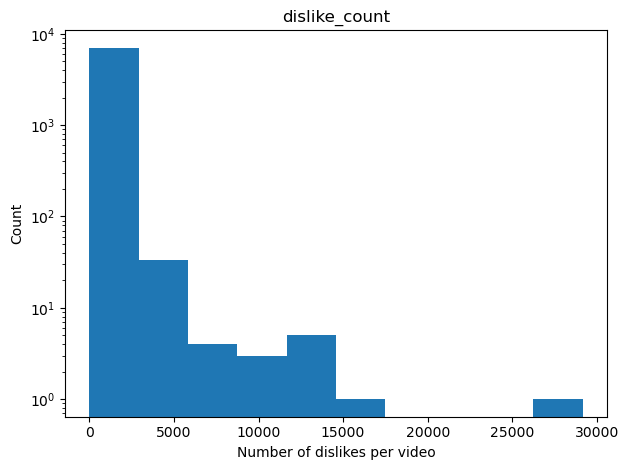

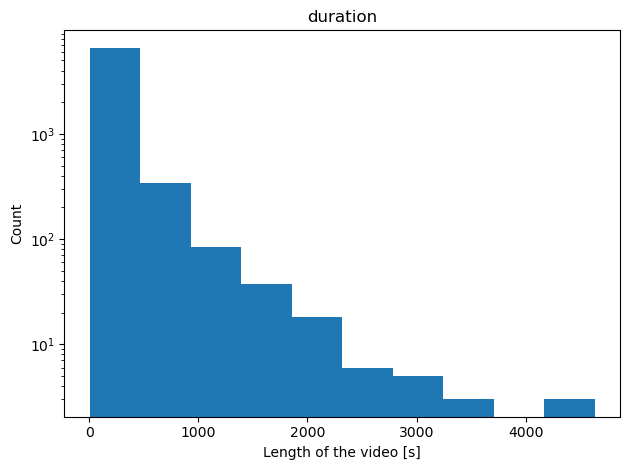

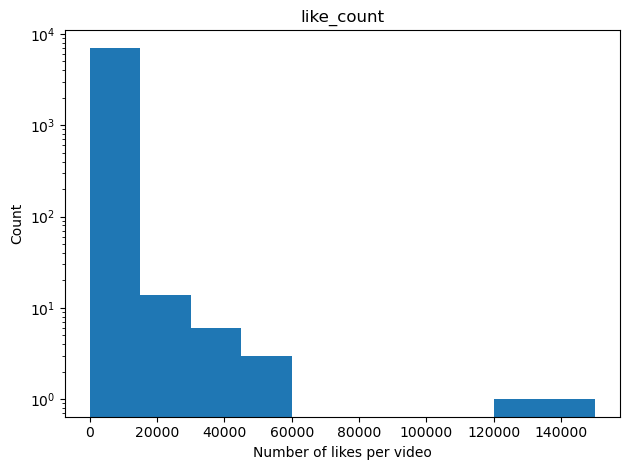

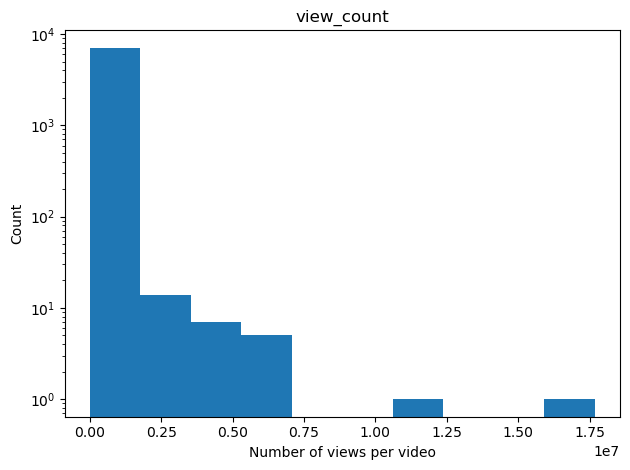

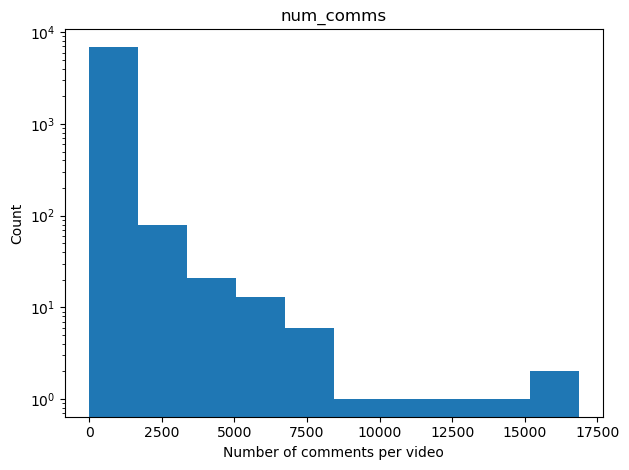

In [17]:
plot_video_characteristics_for_given_channel(grouped_vids, channel_dict['CNN'])

##### Based on timeseries dataframe

In [ ]:
ts_count, ts_mean, ts_std, ts_med = get_general_ch_statistics(filtered_df_timeseries,cols_to_keep=['views', 'delta_views', 'subs','delta_subs','videos','delta_videos','activity'])

In [ ]:
ttest_between_two_channels(filtered_df_timeseries, channel_dict['ABC News'],channel_dict["CNN"], 'activity')

In [ ]:
Ftest_between_two_channels(filtered_df_timeseries, channel_dict['ABC News'],channel_dict["CNN"], 'activity')

### Compare channel's video performance when normalized by size (number of subscribers or number of views)

##### Normalize by subs

In [27]:
def normalize_vids_with_timeseries (df_vid, df_timeseries, feature_to_divide_by):
    
    '''Divide all of the data by the desired feature from the timeseries dataset (number of subs, delta views, ...)
    Note : it should also work for the channel dataframe'''
    
    grouped_ts = df_timeseries.group_by('channel_id').mean()[['channel_id',feature_to_divide_by]]
    merged = df_vid.join(grouped_ts, on='channel_id')
    return merged.with_columns(pl.col(['dislike_count','duration','like_count','view_count']) / merged[feature_to_divide_by])

In [28]:
normalized_df_vid = normalize_vids_with_timeseries(filtered_df_vid, filtered_df_timeseries, 'subs')

In [29]:
#get general statistics for all channel
#gives information on the general performance characteristics of the videos from each channel
grouped_vids = normalized_df_vid.join(filtered_num_comments, on='display_id')
vid_count, vid_mean, vid_std, vid_med = get_general_ch_statistics(grouped_vids, cols_to_keep=['dislike_count','like_count','view_count','num_comms','duration'])

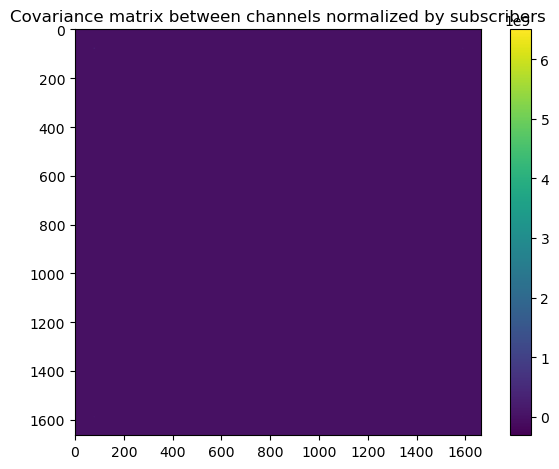

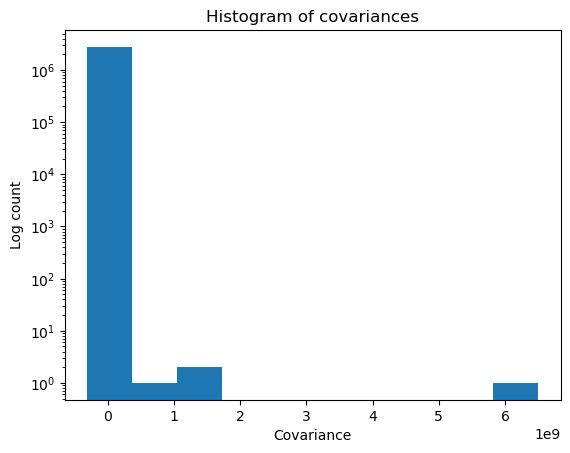

In [30]:
cov = plot_covariance (vid_mean.drop('duration'),'Covariance matrix between channels normalized by subscribers', 'Histogram of covariances')

In [31]:
corrolated_channels = get_correlated_channels(vid_mean,25000)
corrolated_channels

channel_id_1,channel_id_2
str,str
"""UCzOnXvfwc32YEiwTe_8Nf-g""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCzMQMhq7Id0Y_wSDA_CJdGg""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCzIjg5vIfBGcdyLWu6lhXxw""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCzBtT0zEdFpw5O2g_mAIHlw""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCz9jK123qAo5ATWtuuCn8IA""","""UCzUV5283-l5c0oKRtyenj6Q"""
…,…
"""UCsgWR55UyAiFarZYl1u1l9Q""","""UCsvfbwAdMhf9m_zb_pQO4vQ"""
"""UCsdA2TxaEme8CXfkG7R_v_g""","""UCpuofAxlrUAgnu7QEwKQwxw"""
"""UCsdA2TxaEme8CXfkG7R_v_g""","""UC0uVZd8N7FfIZnPu0y7o95A"""


##### Normalize by views

In [50]:
normalized_df_vid = normalize_vids_with_timeseries(filtered_df_vid, filtered_df_timeseries, 'views')

In [51]:
#get general statistics for all channel
#gives information on the general performance characteristics of the videos from each channel
grouped_vids = normalized_df_vid.join(filtered_num_comments, on='display_id')
vid_count, vid_mean, vid_std, vid_med = get_general_ch_statistics(grouped_vids, cols_to_keep=['dislike_count','like_count','view_count','num_comms','duration'])

In [54]:
vid_mean

channel_id,dislike_count,like_count,view_count,num_comms,duration
str,f64,f64,f64,f64,f64
"""UCzUV5283-l5c0oKRtyenj6Q""",0.000002,0.000069,0.001397,3900.410256,7.4679e-7
"""UCzSq7O3MmG-EF0Gq68uSjPw""",4.6505e-7,0.000003,0.00027,12.098592,0.000102
"""UCzSSoloGEz10HALUAbYhngQ""",6.6303e-7,0.000005,0.001182,28.08642,0.000003
"""UCzQ9rowk93wmA6cX8uyp20A""",0.000007,0.000286,0.007701,7.271186,0.008975
"""UCzOnXvfwc32YEiwTe_8Nf-g""",0.000021,0.000238,0.004084,207.457831,0.000763
…,…,…,…,…,…
"""UCs4TGanvFtdeg4E4Muggm9g""",4.4915e-8,3.6404e-7,0.000059,0.828007,0.000007
"""UCs3iFCPtX0gzkKxCrobO4ig""",0.000059,0.001121,0.093216,1351.854839,0.000121
"""UCs1fP1J8BpepNwIfk2qeVkQ""",0.000001,0.000003,0.002814,1.82381,0.000024


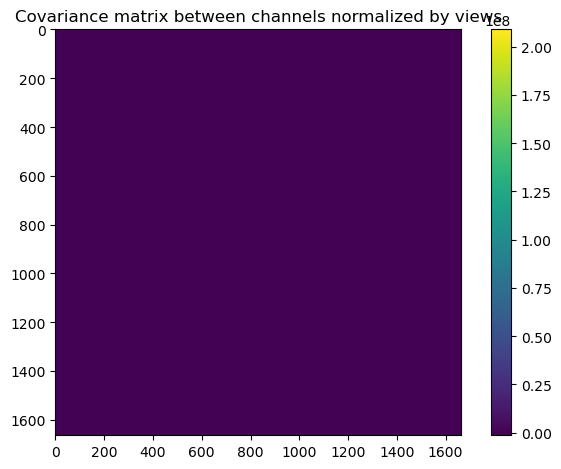

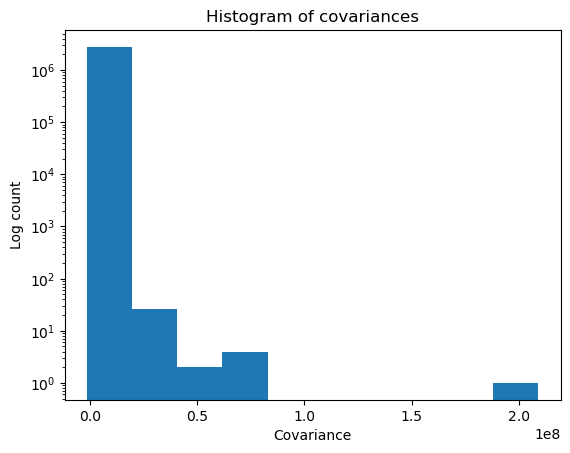

In [52]:
cov = plot_covariance (vid_mean.drop('duration'),'Covariance matrix between channels normalized by views', 'Histogram of covariances')

In [53]:
corrolated_channels = get_correlated_channels(vid_mean,25000)
corrolated_channels

channel_id_1,channel_id_2
str,str
"""UCzOnXvfwc32YEiwTe_8Nf-g""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCzMQMhq7Id0Y_wSDA_CJdGg""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCzIjg5vIfBGcdyLWu6lhXxw""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCzBtT0zEdFpw5O2g_mAIHlw""","""UCzUV5283-l5c0oKRtyenj6Q"""
"""UCz9jK123qAo5ATWtuuCn8IA""","""UCzUV5283-l5c0oKRtyenj6Q"""
…,…
"""UCsgWR55UyAiFarZYl1u1l9Q""","""UCtHtAqU25r70T0lIwjob0fg"""
"""UCsgWR55UyAiFarZYl1u1l9Q""","""UCtB5nbKHYsX8EGIk9cOevaQ"""
"""UCsgWR55UyAiFarZYl1u1l9Q""","""UCt30-N1fyW4evMPMocGlPDg"""


### Compare channel performance across events

In [ ]:
#datasets for first event
timeseries_1 = filtered_df_timeseries
videos_1 = filtered_df_vid
num_comments_1 = filtered_num_comments
channels_1 = filtered_df_ch

In [ ]:
#datasets for second event
timeseries_2 = filtered_df_timeseries
videos_2 = filtered_df_vid
num_comments_2 = filtered_num_comments
channels_2 = filtered_df_ch

In [21]:
#calculate general statistics for both events
grouped_vids_1 = videos_1.join(num_comments_1, on='display_id')
vid_count_1, vid_mean_1, vid_std_1, vid_med_1 = get_general_ch_statistics(grouped_vids_1, cols_to_keep=['dislike_count','like_count','view_count','num_comms'])

grouped_vids_2 = videos_2.join(num_comments_2, on='display_id')
vid_count_2, vid_mean_2, vid_std_2, vid_med_2 = get_general_ch_statistics(grouped_vids_2, cols_to_keep=['dislike_count','like_count','view_count','num_comms'])


ts_count_1, ts_mean_1, ts_std_1, ts_med_1 = get_general_ch_statistics(timeseries_1,cols_to_keep=['views', 'delta_views', 'subs','delta_subs','videos','delta_videos','activity'])
ts_count_2, ts_mean_2, ts_std_2, ts_med_2 = get_general_ch_statistics(timeseries_2,cols_to_keep=['views', 'delta_views', 'subs','delta_subs','videos','delta_videos','activity'])

##### Compare general channel performance between multiple events

In [22]:
df_1 = vid_mean_1.mean()
df_2 = vid_mean_2.mean()

event_performance = pl.concat([df_1,df_2])

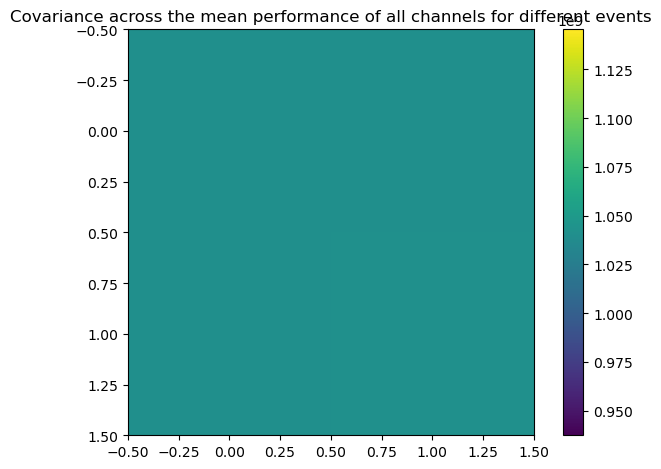

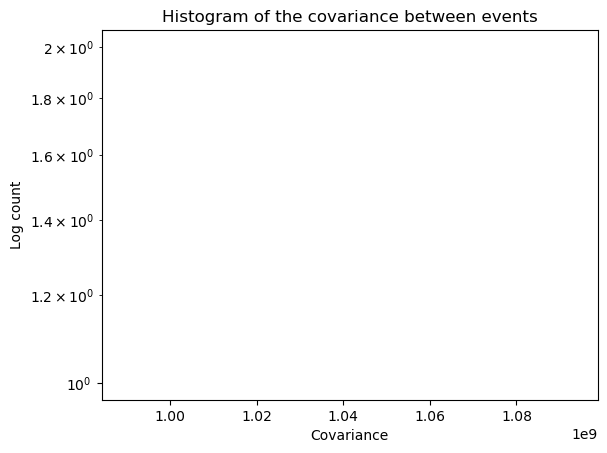

In [23]:
#Covariance matrix for the channel performance to identify channels that perform similarly for a given event.
cov = plot_covariance(event_performance,'Covariance across the mean performance of all channels for different events','Histogram of the covariance between events')

##### Compare a given channel statistic between two events

In [ ]:
# ttest : checks the null hypothesis that a given parameter has the same mean across between two events
# used to compare if two means differ significantly or not

ttest_between_events(ts_mean_1['activity'], ts_mean_2['activity'])

In [ ]:
# Ftest : checks the null hypothesis that a given parameter has the same variance across between two events
# used to compare if two means differ significantly or not

Ftest_between_events(ts_mean_1['activity'], ts_mean_2['activity'])

# Compare between kinds of events and where events are from
    - how many videos
    - how many views
    - interactions: likes, comments

In [ ]:
#compute general statistics for each event

vid_count_1, vid_mean_1, vid_std_1, vid_med_1 = get_general_ch_statistics(videos_1)
vid_count_2, vid_mean_2, vid_std_2, vid_med_2 = get_general_ch_statistics(videos_2)

ts_count_1, ts_mean_1, ts_std_1, ts_med_1 = get_general_ch_statistics(timeseries_1,['views', 'delta_views', 'subs','delta_subs','videos','delta_videos','activity'])
ts_count_2, ts_mean_2, ts_std_2, ts_med_2 = get_general_ch_statistics(timeseries_2,['views', 'delta_views', 'subs','delta_subs','videos','delta_videos','activity'])

### Compare number of videos

In [ ]:
#compare number of videos between two events

compare_overall_vid_count_between_events(vid_count_1, vid_count_2)

In [ ]:
# Compare average number of videos per channel between two events
ttest_between_events(vid_count_1['counts'], vid_count_2['counts'])

In [ ]:
# Compare variance of the number of videos per channel between two events
Ftest_between_events(vid_count_1['counts'], vid_count_2['counts'])

### Analyse each event by videos (number of views, number of likes/dislikes)

In [ ]:
v_means_1,v_stdevs_1,v_medians_1 = get_general_vid_statistics(videos_1)
v_means_2,v_stdevs_2,v_medians_2 = get_general_vid_statistics(videos_2)

In [ ]:
pl.concat([v_means_1,v_means_2]).insert_column(0,pl.Series(['event_1','event_2']))

In [ ]:
compare_video_statistics_between_events(videos_1,videos_2)

In [ ]:
ttest_between_events(videos_1['view_count'], videos_2['view_count'])

# How many comments have replies in each video
    - See distributions across different channels/topics
    - LET JEFF KNOW IF YOU NEED HELP WITH THIS